# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.757531,True,11.247696
1,-0.116686,False,-1.726319
2,0.606378,True,6.548897
3,1.924467,True,10.587512
4,1.903015,True,10.938026
...,...,...,...
995,-1.224378,False,-4.613622
996,0.103347,True,6.107808
997,1.236580,True,9.622578
998,1.344063,True,7.495473


<AxesSubplot: xlabel='v0'>

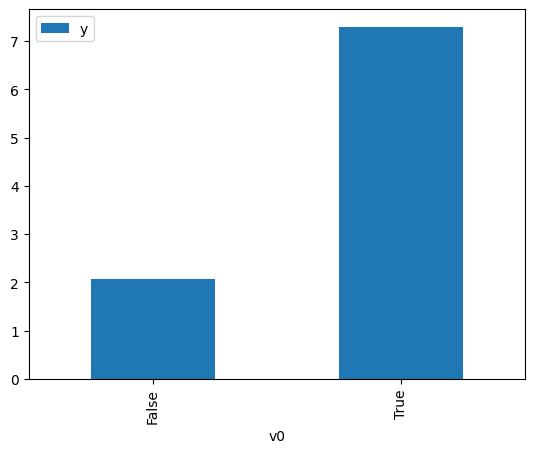

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

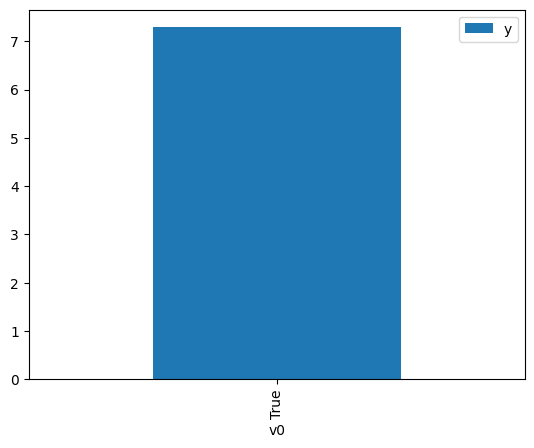

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.665643,False,4.753494,0.070752,14.133784
1,1.751020,False,4.152029,0.062602,15.973804
2,1.659096,False,5.050302,0.071416,14.002398
3,1.432994,False,4.597534,0.098154,10.188093
4,-0.254376,False,-1.201178,0.592277,1.688399
...,...,...,...,...,...
995,1.994555,False,6.075498,0.043927,22.764884
996,2.052103,False,6.801419,0.040362,24.775944
997,1.072981,False,1.967752,0.159087,6.285864
998,0.330512,False,-1.150401,0.371725,2.690164


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.038056,True,1.790435,0.171237,5.839857
1,-0.651062,True,2.892726,0.272381,3.671333
2,0.454081,True,7.826548,0.671415,1.489392
3,1.354377,True,9.037255,0.890628,1.122803
4,0.150989,True,5.892836,0.561963,1.779477
...,...,...,...,...,...
995,-0.265536,True,3.032898,0.403591,2.477757
996,1.030371,True,6.921974,0.831963,1.201977
997,-0.503571,True,2.865112,0.319499,3.129902
998,1.180012,True,8.214292,0.861691,1.160509


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          2.483e+04
Date:                Tue, 14 Mar 2023   Prob (F-statistic):                        0.00
Time:                        17:06:04   Log-Likelihood:                         -1450.2
No. Observations:                1000   AIC:                                      2904.
Df Residuals:                     998   BIC:                                      2914.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9100      0.038     76.916      0.000       2.836       2.984
x2             4.9972      0.057     87.618      0.000       4.885       5.109
==============================================================================
Omnibus:                        0.262   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.299
Skew:                           0.038   Prob(JB):                        0.861
Kurtosis:                       2.963   Cond. No.                         2.81
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""